In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.animation as animation
from functools import partial

In [2]:
def get_pdf(x, y, sigma):# sigma in [0,1]
    pos = np.dstack((x, y))
    sigma = sigma * 20 + 5
    mode_a = multivariate_normal(mean=[-4,-6], cov=sigma * np.array([[3,0], [0,3]]))
    mode_b = multivariate_normal(mean=[15,15], cov=sigma * np.array([[6,3], [3,6]]))
    mode_c = multivariate_normal(mean=[10,-10], cov=sigma * np.array([[6,3], [3,6]]))
    z = (mode_a.pdf(pos) + mode_b.pdf(pos) + mode_c.pdf(pos)) / 3
    return z

def get_gradient(sample_loc, sigma):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    x += sample_loc[0]
    y += sample_loc[1]
    z = get_pdf(x, y, sigma)
    gradiend_x, gradient_y = np.gradient(np.log(z))
    return np.array([gradiend_x[30,30], gradient_y[30,30]])

def langevin_sample(x_t, step_size, sigma):
    gradient = step_size * get_gradient(x_t, sigma=sigma) * 100
    noise = np.array([np.random.normal(0,1), np.random.normal(0,1)]) * np.sqrt(2 * step_size)
    return x_t + gradient + noise

def plot_surfaces(ax_0, ax_1, sigma):
    x, y = np.mgrid[-20:20:.1, -20:20:.1]
    ax_0.set_zticklabels([])
    ax_0.set_zlim(0, 0.0035)
    ax_1.set_xticks([]), ax_1.set_yticks([])
    ax_1.set_aspect('equal')
    z = get_pdf(x, y, sigma=sigma)
    ax_0.plot_surface(x,y,z, lw=0.2, rstride=10, cstride=10, edgecolor='blue',
            alpha=0.9, cmap='Blues')
    ax_1.contourf(x, y, z, cmap='Blues', levels=np.linspace(0, 0.004, 30))

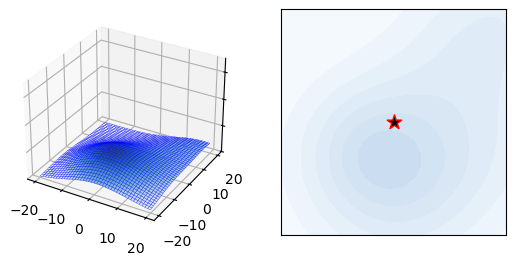

In [3]:
fig = plt.figure()
ax_0 = fig.add_subplot(121, projection='3d')
ax_1 = fig.add_subplot(122, xticks=[], yticks=[], aspect='equal')

plot_surfaces(ax_0, ax_1, sigma=1)
ax_1.scatter(0,0, marker='*', s=120, c='k', edgecolor='r', linewidth=1)

In [ ]:
sigmas = np.power(np.linspace(0, 1, 200), 2)# increasing
step_sizes = np.linspace(0.01, 0.1, 200) # increasing
fig = plt.figure()
ax_0 = fig.add_subplot(121, projection='3d')
ax_1 = fig.add_subplot(122, xticks=[], yticks=[], aspect='equal')
path = [np.array([-18,18])]
def update(n, direction, const_noise=True):
    ax_0.cla(), ax_1.cla()
    _sigmas = sigmas[::-1 if direction == 'backward' else 1]
    _step_sizes = step_sizes[::-1 if direction == 'backward' else 1]
    sigma, step_size = _sigmas[n], _step_sizes[n]
    sigma = 0 if const_noise else sigma
    plot_surfaces(ax_0, ax_1, sigma=sigma)

    if direction == 'backward':
        path.append(
            langevin_sample(path[-1], step_size=step_size, sigma=sigma)
        )
        _path = np.array(path)
        ax_1.plot(_path[:n+1, 0], _path[:n+1, 1], c='r', zorder=50)
        ax_1.scatter(_path[n][0], _path[n][1], marker='*', c='k', zorder=100, s=120, edgecolor='w', linewidth=1)

    return fig,

direction, const = 'backward', False
filename = f"{direction}" + ("_const" if const else "")
_update = partial(update, direction=direction, const_noise=const)
anim = animation.FuncAnimation(fig=fig, func=_update, frames=199, interval=1, repeat=False)
anim.save(f'{filename}.gif', fps=10) #
####################################################################################################
###################### There are better implemantation for gif creation. See .../Lipman2023FlowMathing/...
####################################################################################################